# EDA: DCASE 2020 Challenge Task 2 - 3CNN Autoencoder Analysis

This notebook provides exploratory data analysis for the DCASE 2020 Challenge Task 2 dataset used in the 3CNN Autoencoder approach.

- [DCASE 2020 Challenge Task 2](http://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds)
- [Development Dataset](https://zenodo.org/record/3678171#.XnGwM5P7SL4)

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Import local modules
import common as com
from image_common import file_to_vector_array_2d

sns.set_palette('husl')
%matplotlib inline

## Dataset Location

Set the path to your data directory. The default assumes data is in `../data/` relative to the ML folder.

In [2]:
# Set your data folder here
DATA_ROOT = Path('../data')
TRAIN_DIR = DATA_ROOT / 'train'
TEST_DIR = DATA_ROOT / 'test'

print(f'Data root: {DATA_ROOT.absolute()}')
print(f'Train directory exists: {TRAIN_DIR.exists()}')
print(f'Test directory exists: {TEST_DIR.exists()}')

Data root: c:\Users\TEMP\Documents\kaanich\dcase2020_task2_variants\ML\..\data
Train directory exists: True
Test directory exists: True


## Basic Statistics

Let's explore the structure of the dataset.

In [3]:
# Collect all WAV files
train_files = sorted(TRAIN_DIR.glob('**/*.wav')) if TRAIN_DIR.exists() else []
test_files = sorted(TEST_DIR.glob('**/*.wav')) if TEST_DIR.exists() else []

print(f'Training files: {len(train_files)}')
print(f'Test files: {len(test_files)}')

if len(train_files) > 0:
    print(f'\nExample train file: {train_files[0].name}')
if len(test_files) > 0:
    print(f'Example test file: {test_files[0].name}')

Training files: 3349
Test files: 856

Example train file: normal_id_00_00000000.wav
Example test file: anomaly_id_00_00000000.wav


In [4]:
# Create DataFrame with file information
df = pd.DataFrame()
all_files = train_files + test_files

if len(all_files) > 0:
    df['file'] = all_files
    df['split'] = ['train' if f in train_files else 'test' for f in all_files]
    df['filename'] = df.file.map(lambda f: f.name)
    
    # Extract label from filename (normal vs anomaly)
    df['label'] = df.filename.map(lambda f: 'normal' if 'normal' in f.lower() else 'anomaly' if 'anomaly' in f.lower() else 'unknown')
    
    print(f'Total files: {len(df)}')
    print(f'\nFiles per split:')
    print(df.groupby(['split', 'label']).size())
else:
    print('No WAV files found. Please check your data directory path.')

Total files: 4205

Files per split:
split  label  
test   anomaly     456
       normal      400
train  normal     3349
dtype: int64


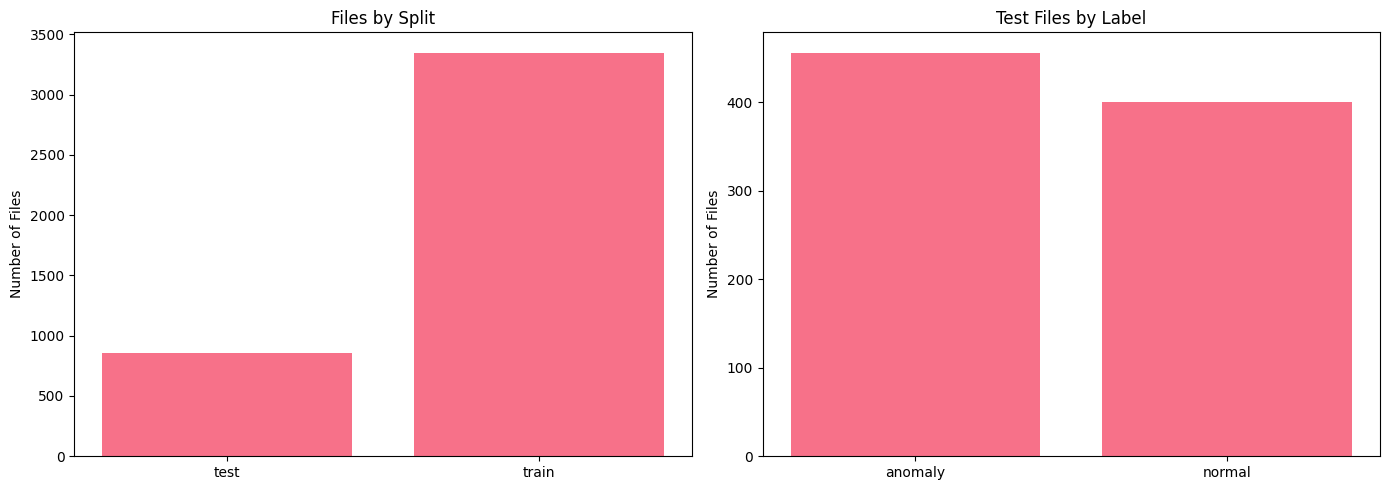

In [5]:
# Visualize file distribution
if len(df) > 0:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Files by split
    split_counts = df.groupby('split').size()
    ax[0].bar(split_counts.index, split_counts.values)
    ax[0].set_title('Files by Split')
    ax[0].set_ylabel('Number of Files')
    
    # Files by label (test set only)
    test_df = df[df.split == 'test']
    if len(test_df) > 0:
        label_counts = test_df.groupby('label').size()
        ax[1].bar(label_counts.index, label_counts.values)
        ax[1].set_title('Test Files by Label')
        ax[1].set_ylabel('Number of Files')
    
    plt.tight_layout()
    plt.show()

## Audio File Properties

Let's examine the properties of the audio files.

In [6]:
# Sample a few files to check properties
if len(train_files) > 0:
    sample_files = train_files[:5]
    
    for f in sample_files:
        try:
            wav, sr = com.file_load(str(f))
            duration = len(wav) / sr
            print(f'{f.name}:')
            print(f'  Sampling rate: {sr} Hz')
            print(f'  Duration: {duration:.2f} seconds')
            print(f'  Samples: {len(wav)}')
            print()
        except Exception as e:
            print(f'Error loading {f.name}: {e}')

normal_id_00_00000000.wav:
  Sampling rate: 16000 Hz
  Duration: 10.00 seconds
  Samples: 160000

normal_id_00_00000001.wav:
  Sampling rate: 16000 Hz
  Duration: 10.00 seconds
  Samples: 160000

normal_id_00_00000002.wav:
  Sampling rate: 16000 Hz
  Duration: 10.00 seconds
  Samples: 160000

normal_id_00_00000003.wav:
  Sampling rate: 16000 Hz
  Duration: 10.00 seconds
  Samples: 160000

normal_id_00_00000004.wav:
  Sampling rate: 16000 Hz
  Duration: 10.00 seconds
  Samples: 160000



## Mel Spectrogram Features

The 3CNN Autoencoder uses mel spectrogram features. Let's visualize how the preprocessing works.

In [7]:
# Load configuration
from argparse import Namespace

config_path = Path('config.yaml')
if config_path.exists():
    params = Namespace(**com.yaml_load(str(config_path)))
    params.feature = Namespace(**params.feature)
    print('Configuration loaded:')
    print(f'  n_mels: {params.feature.n_mels}')
    print(f'  n_fft: {params.feature.n_fft}')
    print(f'  hop_length: {params.feature.hop_length}')
    print(f'  power: {params.feature.power}')
else:
    print('config.yaml not found, using default parameters')
    params = Namespace(
        feature=Namespace(
            n_mels=128,
            n_fft=1024,
            hop_length=512,
            power=2.0
        )
    )

Configuration loaded:
  n_mels: 128
  n_fft: 1024
  hop_length: 512
  power: 2.0


normal_id_00_00000000.wav: Generated 9 vectors of shape (128, 128)
normal_id_00_00000001.wav: Generated 9 vectors of shape (128, 128)
normal_id_00_00000002.wav: Generated 9 vectors of shape (128, 128)
normal_id_00_00000003.wav: Generated 9 vectors of shape (128, 128)


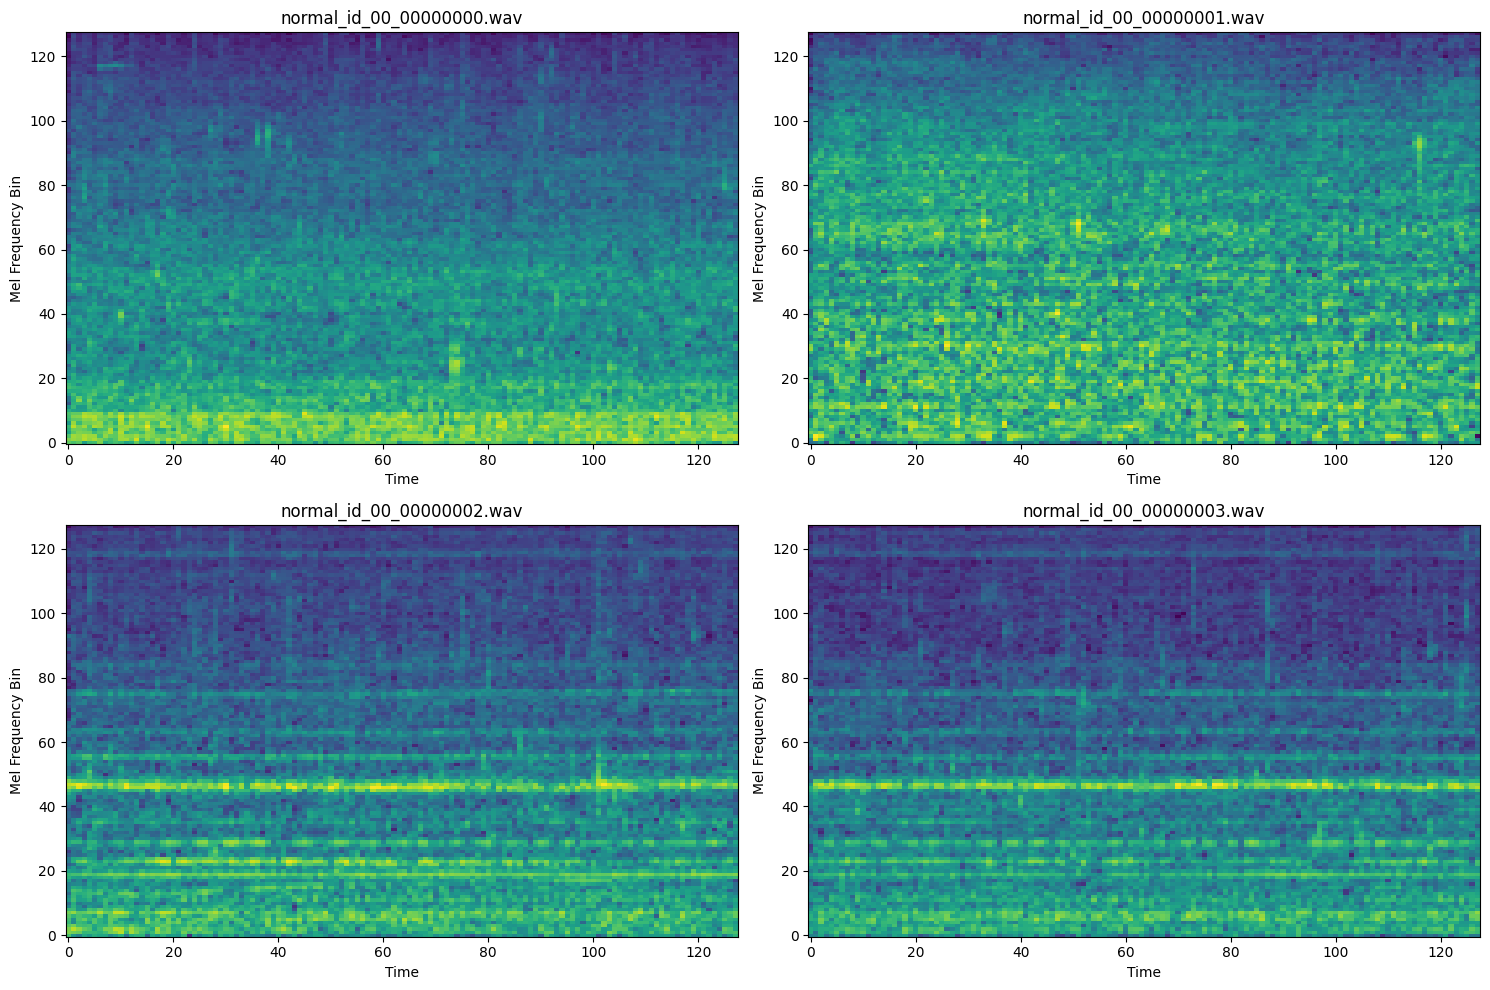

In [8]:
# Visualize preprocessed features from sample files
if len(train_files) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    sample_files = train_files[:4]
    
    for i, f in enumerate(sample_files):
        try:
            # Use the same preprocessing as the model
            vectors = file_to_vector_array_2d(
                str(f),
                n_mels=params.feature.n_mels,
                steps=20,
                n_fft=params.feature.n_fft,
                hop_length=params.feature.hop_length,
                power=params.feature.power
            )
            
            # Display the first vector as an image
            if len(vectors) > 0:
                axes[i].imshow(vectors[0], aspect='auto', origin='lower', cmap='viridis')
                axes[i].set_title(f.name)
                axes[i].set_xlabel('Time')
                axes[i].set_ylabel('Mel Frequency Bin')
                print(f'{f.name}: Generated {len(vectors)} vectors of shape {vectors[0].shape}')
        except Exception as e:
            print(f'Error processing {f.name}: {e}')
    
    plt.tight_layout()
    plt.show()

## Feature Statistics

Let's analyze the distribution of features across the dataset.


Combined features shape: (90, 128, 128)
Mean: -29.7504
Std: 8.2747
Min: -60.7198
Max: 0.4382


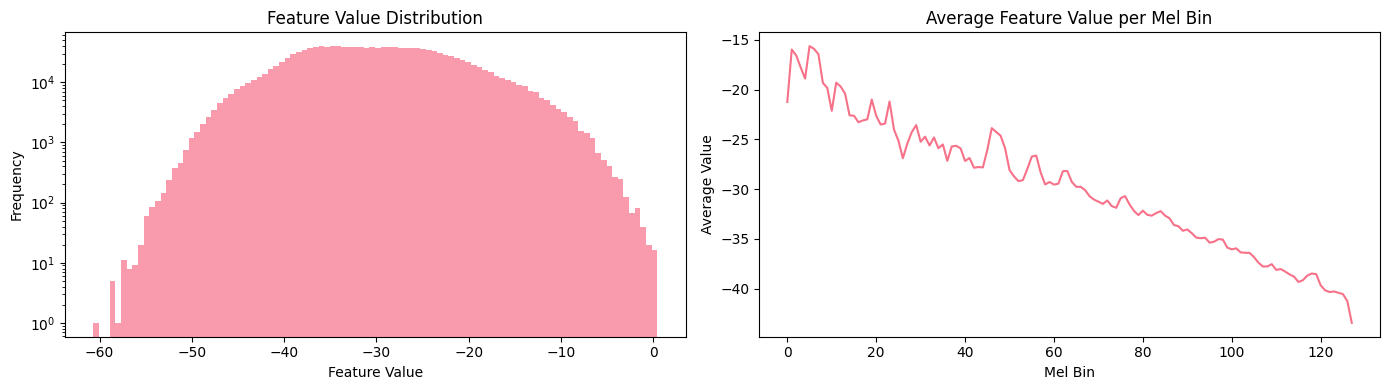

In [9]:
# Collect features from a sample of files
if len(train_files) > 0:
    print('Collecting features from training files (this may take a moment)...')
    
    sample_size = min(10, len(train_files))
    all_vectors = []
    
    for f in train_files[:sample_size]:
        try:
            vectors = file_to_vector_array_2d(
                str(f),
                n_mels=params.feature.n_mels,
                steps=20,
                n_fft=params.feature.n_fft,
                hop_length=params.feature.hop_length,
                power=params.feature.power
            )
            if len(vectors) > 0:
                all_vectors.append(vectors)
        except Exception as e:
            print(f'Error processing {f.name}: {e}')
    
    if len(all_vectors) > 0:
        combined = np.concatenate(all_vectors, axis=0)
        print(f'\nCombined features shape: {combined.shape}')
        print(f'Mean: {combined.mean():.4f}')
        print(f'Std: {combined.std():.4f}')
        print(f'Min: {combined.min():.4f}')
        print(f'Max: {combined.max():.4f}')
        
        # Plot distribution
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        
        # Histogram
        axes[0].hist(combined.flatten(), bins=100, alpha=0.7)
        axes[0].set_title('Feature Value Distribution')
        axes[0].set_xlabel('Feature Value')
        axes[0].set_ylabel('Frequency')
        axes[0].set_yscale('log')
        
        # Mean across mel bins
        mean_per_bin = combined.mean(axis=0).mean(axis=1)
        axes[1].plot(mean_per_bin)
        axes[1].set_title('Average Feature Value per Mel Bin')
        axes[1].set_xlabel('Mel Bin')
        axes[1].set_ylabel('Average Value')
        
        plt.tight_layout()
        plt.show()

## Summary

This notebook provides an overview of the data used for the 3CNN Autoencoder approach:
- Audio files are converted to mel spectrograms
- Features are extracted using a sliding window approach
- The model learns to reconstruct these features and uses reconstruction error for anomaly detection